# INTRODUCTION

This Python project analyzes the relationship between socio-economic factors and drug overdose deaths across counties in the US. The analysis explores variables such as unemployment rates and low education rates to determine their predictive power regarding overdose death rates, with the aim of uncovering insights that can inform public health strategies and interventions.

NEXT STEPS:
* split urban/rural analysis

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
# SOURCES
# overdoses from https://data.cdc.gov/NCHS/NCHS-Drug-Poisoning-Mortality-by-County-United-Sta/rpvx-m2md/about_data
# education and unemployment from https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/
# poverty from https://www.census.gov/data/datasets/2019/demo/saipe/2019-state-and-county.html
# depression from https://mhanational.org/mhamapping/mha-state-county-data

path = './data/'

overdoses = pd.read_csv(path + 'NCHS_-_Drug_Poisoning_Mortality_by_County__United_States.csv')
education = pd.read_csv(path + 'national-Education.csv')
unemployment = pd.read_csv(path + 'national-Unemployment.csv')
poverty = pd.read_csv(path + 'national-poverty.csv', dtype={'County FIPS Code': str})
depression = pd.read_csv(path + 'national-depression.csv', encoding='ISO-8859-1')

# CLEANING

## CLEAN OVERDOSES

In [6]:
year = 2019
overdoses = overdoses[overdoses['Year'] == year]
overdoses = overdoses.loc[:,['FIPS','State','County','Population','Model-based Death Rate','Urban/Rural Category']]
overdoses.loc[:,'Population'] = overdoses['Population'].str.replace(',','').astype(int)
overdoses = overdoses.rename(columns={'Model-based Death Rate':'Overdose Death Rate'})
overdoses['FIPS'] = overdoses['FIPS'].astype(str)
overdoses['County'] = overdoses['County'].str.split(' County').str[0] # strip ' County, XX' where it appears
overdoses['County'] = overdoses['County'].str.split(' Borough').str[0]
overdoses['County'] = overdoses['County'].str.split(' Census Area').str[0]

## CLEAN EDUCATION

In [8]:
education = education.loc[:,['State','Area name','FIPS Code','Percent of adults with less than a high school diploma, 2018-22']]
education = education.rename(columns={'FIPS Code':'FIPS','Percent of adults with less than a high school diploma, 2018-22':'Low Education Rate'})

# Connecticut's data is weird. Data is aggregated by 'planning region', and not by county. Other datasets are by county.
# Fix this first before dealing with NAs and outliers.
# There isn't a 1-1 connection between planning region and county, but there's enough overlap to approximate a county's values from a planning region.
education.loc[education['FIPS']==9001,'Low Education Rate'] = (education.loc[education['FIPS']==9190,'Low Education Rate'] + education.loc[education['FIPS']==9120,'Low Education Rate']) / 2
education.loc[education['FIPS']==9003, 'Low Education Rate'] = education.loc[education['FIPS']==9110, 'Low Education Rate']
education.loc[education['FIPS']==9005, 'Low Education Rate'] = education.loc[education['FIPS']==9160, 'Low Education Rate']
education.loc[education['FIPS']==9007, 'Low Education Rate'] = education.loc[education['FIPS']==9130, 'Low Education Rate']
education.loc[education['FIPS']==9009, 'Low Education Rate'] = education.loc[education['FIPS']==9170, 'Low Education Rate']
education.loc[education['FIPS']==9011, 'Low Education Rate'] = education.loc[education['FIPS']==9180, 'Low Education Rate']
education.loc[education['FIPS']==9013, 'Low Education Rate'] = education.loc[education['FIPS']==9110, 'Low Education Rate']
education.loc[education['FIPS']==9015, 'Low Education Rate'] = education.loc[education['FIPS']==9150, 'Low Education Rate']

# 11 real NAs after fixing CT, mostly for very remote areas (Aleutian Islands AK, Upper Yukon AK, Yellowstone, etc..
# Let's drop these values since they're more likely to be outliers anyways.
education = education.dropna(subset='Low Education Rate')
education.sort_values(['Low Education Rate']).tail(20)

education = education.loc[:,['FIPS','Low Education Rate']]
education['FIPS'] = education['FIPS'].astype(str)

## CLEAN UNEMPLOYMENT

In [10]:
unemployment = unemployment.loc[:,['State','Area_Name','FIPS_Code','Unemployment_rate_2019']]
unemployment = unemployment.rename(columns={'FIPS_Code':'FIPS','Unemployment_rate_2019':'Unemployment Rate'})

# 5 na values, all for remote areas in Alaska. Let's just drop these rows, since they're more likely to be outliers anyways
unemployment = unemployment.dropna(subset='Unemployment Rate')
unemployment = unemployment.loc[:,['FIPS','Unemployment Rate']]

unemployment['FIPS'] = unemployment['FIPS'].astype(str)

## CLEAN POVERTY

In [12]:
poverty.loc[:,['State FIPS Code','County FIPS Code']] = poverty.loc[:,['State FIPS Code','County FIPS Code']].astype(str)
poverty.loc[:,'FIPS'] = poverty['State FIPS Code'] + poverty['County FIPS Code']
poverty = poverty.loc[:,['FIPS','Poverty Percent, All Ages']]
poverty = poverty.rename(columns={'Poverty Percent, All Ages':'Poverty Rate'})
poverty.loc[poverty['Poverty Rate'] == '.', 'Poverty Rate'] = np.nan
poverty['Poverty Rate'] = poverty['Poverty Rate'].astype('float')

# 1 NA
poverty = poverty.dropna(subset='Poverty Rate')

## CLEAN DEPRESSION

In [14]:
depression = depression.loc[:,['County Name','State','# per 100K']]
depression = depression.rename(columns={'County Name':'County','# per 100K':'Depression Rate'})

# MERGING

In [16]:
# match on fips code, inner join (default behavior)

df = pd.merge(overdoses, education, on='FIPS', how='inner')
df = pd.merge(df, unemployment, on='FIPS', how='inner')
df = pd.merge(df, poverty, on='FIPS', how='inner')
df = pd.merge(df, depression, on=['State','County'], how='left')

# imputing medians for NA depression rates since there were more blanks for that survey
df['Depression Rate'] = df['Depression Rate'].fillna(df['Depression Rate'].median())
# total of 3143 counties in the us, we have 3121 of them represented here after dropping/imputing NAs. Should be sufficient

response = 'Overdose Death Rate'
numeric_predictors = [
    'Low Education Rate',
    'Unemployment Rate',
    'Poverty Rate',
    'Depression Rate'
]
categorical_predictors = [
    'Urban/Rural Category'
]
numeric_cols = [response] + numeric_predictors

# UNIVARIATE ANALYSIS

Univariate analysis revealed that before removing outliers, our death rates, unemployment rates, low-education rates, poverty rates, and depression rates are all unimodal and right skewed.

Note that depression rates have a single very frequent mode at the previously imputed median, as we'd expect.

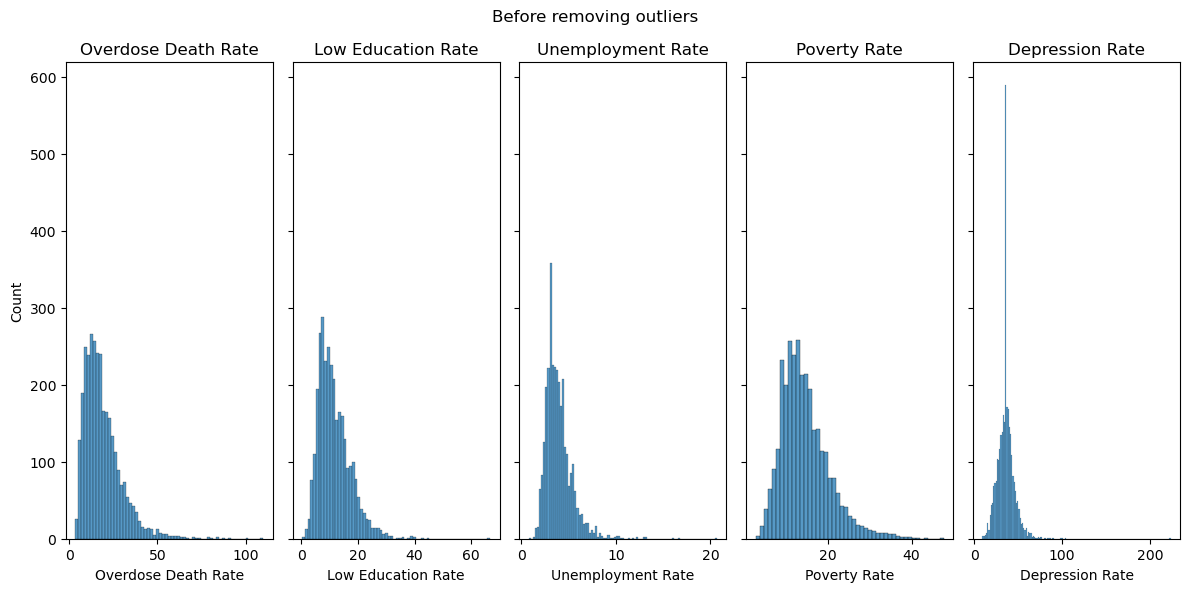

In [18]:
def univariate_analysis(df, cols, suptitle=None):
  num_cols = len(cols)
  fig, axes = plt.subplots(1, num_cols, figsize=(12,6), sharey=True)

  for i, col in enumerate(cols):
    sns.histplot(df[col], ax=axes[i])
    axes[i].set_title(col)

  plt.suptitle(suptitle)
  plt.tight_layout()
  plt.show


univariate_analysis(df, numeric_cols, 'Before removing outliers')

# CLEANING OUTLIERS

After removing outliers, our data looks much more symmetric, although overdose death rate and low education rate are still slightly right-skewed.

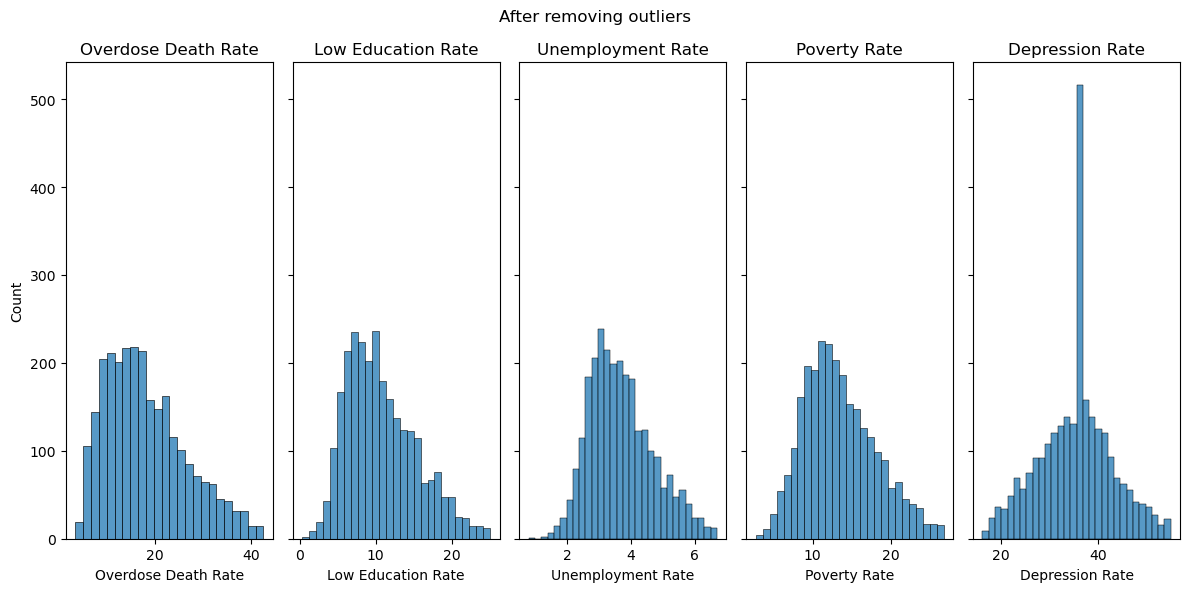

In [20]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

for col in numeric_cols:
  df = remove_outliers(df, col)

# left with 2577 out of 3143 counties in us after cleaning, enough to proceed

univariate_analysis(df, numeric_cols,'After removing outliers')

# BIVARIATE ANALYSIS

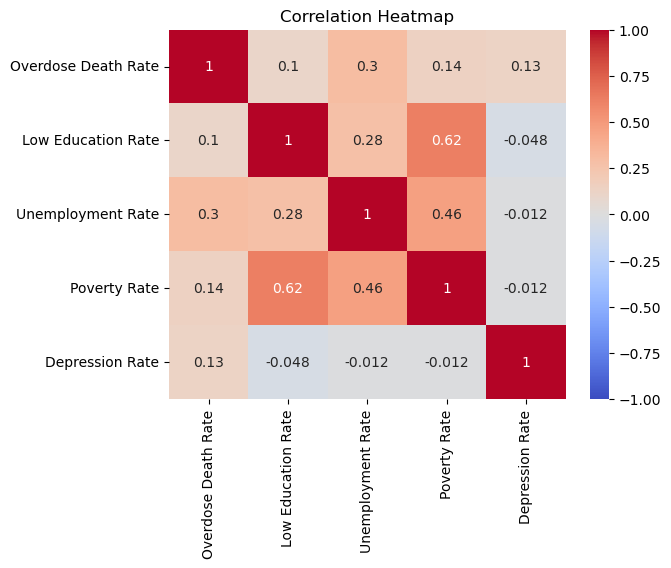

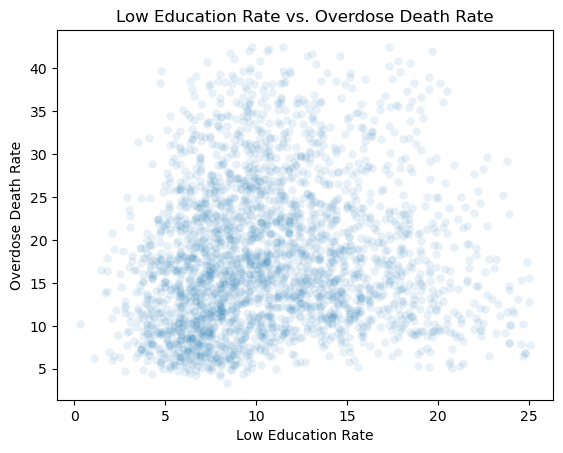

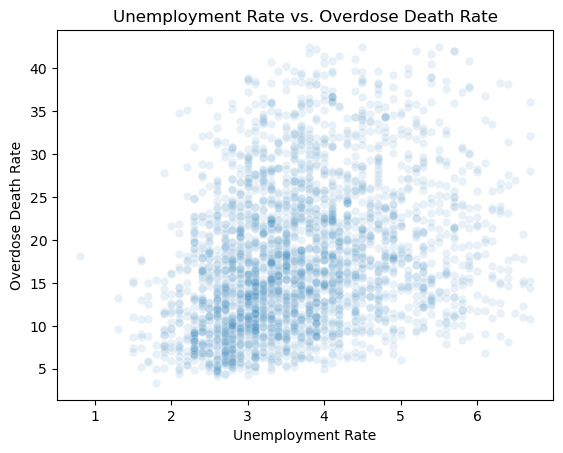

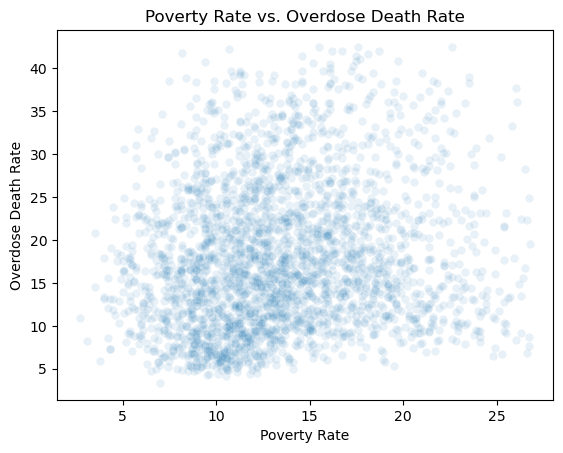

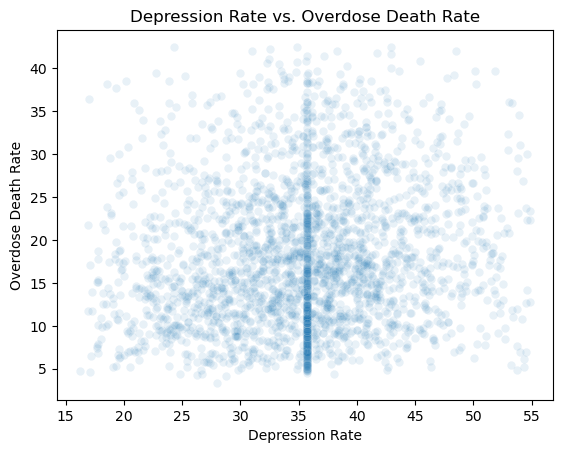

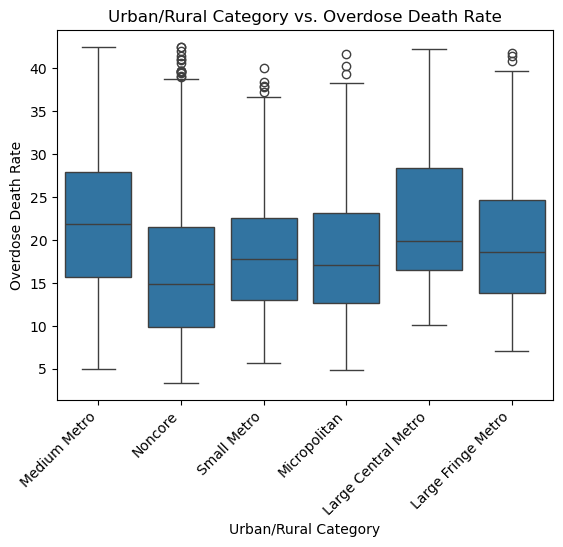

In [22]:
def show_correlation_heatmap(df, cols):
  corr = df[cols].corr()
  sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title('Correlation Heatmap')
  plt.show()

def cont_bivariate_analysis(df, predictor, response, alpha=1.0):
  sns.scatterplot(x=predictor, y=response, data=df, alpha=alpha)
  plt.xlabel(predictor)
  plt.ylabel(response)
  plt.title(f'{predictor} vs. {response}')
  plt.show()

def cat_bivariate_analysis(df, predictor, response):
  sns.boxplot(x=predictor, y=response, data=df)
  plt.xticks(rotation=45, ha='right')
  plt.xlabel(predictor)
  plt.ylabel(response)
  plt.title(f'{predictor} vs. {response}')
  plt.show()

# setup
alpha = 0.1
strat = 'Urban/Rural Category'

# displays
show_correlation_heatmap(df, numeric_cols)

for predictor in numeric_predictors:
  cont_bivariate_analysis(df, predictor, response, alpha=alpha)

for predictor in categorical_predictors:
  cat_bivariate_analysis(df, predictor, response)

# SPLIT URBAN/RURAL ANALYSIS

In [24]:
# TODO divide by Urban/Rural Category and run analyses

# REGRESSION

In [26]:
def ml_model(model, df, response, predictors):
  y = df[response]
  X = df[predictors]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print("-------" + str(model) + "-------")
  print(f'Mean Squared Error: {round(mse,2)}')
  print(f'Mean Absolute Error: {round(mae,2)}')
  print(f'R-squared: {round(r2,2)}')

# declare models
lm = LinearRegression()
random_state = 88
max_depth = 10
rf_500 = RandomForestRegressor(n_estimators=500, max_depth=max_depth,random_state=random_state)
rf_100 = RandomForestRegressor(n_estimators=100, max_depth=max_depth,random_state=random_state)
rf_50 = RandomForestRegressor(n_estimators=50, max_depth=max_depth,random_state=random_state)
svr = SVR()

# run and test models
ml_model(lm, df, response, numeric_predictors)
ml_model(rf_500, df, response, numeric_predictors)
ml_model(rf_100, df, response, numeric_predictors)
ml_model(rf_50, df, response, numeric_predictors)
ml_model(svr, df, response, numeric_predictors)

-------LinearRegression()-------
Mean Squared Error: 60.42
Mean Absolute Error: 6.32
R-squared: 0.08
-------RandomForestRegressor(max_depth=10, n_estimators=500, random_state=88)-------
Mean Squared Error: 56.87
Mean Absolute Error: 6.1
R-squared: 0.14
-------RandomForestRegressor(max_depth=10, random_state=88)-------
Mean Squared Error: 57.15
Mean Absolute Error: 6.12
R-squared: 0.13
-------RandomForestRegressor(max_depth=10, n_estimators=50, random_state=88)-------
Mean Squared Error: 58.5
Mean Absolute Error: 6.15
R-squared: 0.11
-------SVR()-------
Mean Squared Error: 62.09
Mean Absolute Error: 6.25
R-squared: 0.06
